In [25]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import label, remove_small_objects
from skimage.measure import label, regionprops
from math import sqrt, pi

In [36]:
from glob import glob
img_path = glob('{}*{}'.format('Dataset/*/tissue images/', 'png'))
binary_mask_path = glob('{}*{}'.format('Dataset/*/mask binary/', 'png'))
distance_mask_path = glob('{}*{}'.format('Dataset/*/distance maps/', 'png'))
label_mask_path = glob('{}*{}'.format('Dataset/*/label masks modify/', 'tif'))

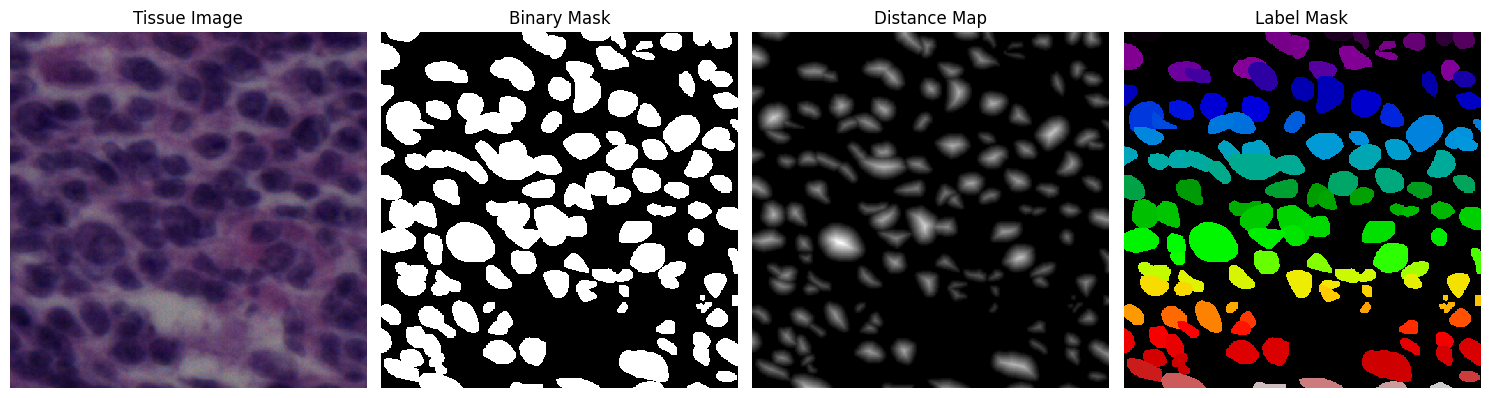

In [40]:
x=25
img = imread(img_path[x])
binary_mask = imread(binary_mask_path[x])
distance_mask = imread(distance_mask_path[x])
label_mask = imread(label_mask_path[x])
plt.figure(figsize=(15, 5))
titles = ['Tissue Image', 'Binary Mask', 'Distance Map', 'Label Mask']
images = [img, binary_mask, distance_mask,label_mask]
cmaps = [None, 'gray', 'gray', 'nipy_spectral']

for i, (im, title, cmap) in enumerate(zip(images, titles, cmaps), start=1):
    ax = plt.subplot(1, 4, i)
    if cmap:
        ax.imshow(im, cmap=cmap, interpolation='none')
    else:
        ax.imshow(im, interpolation='none')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [10]:


# --- CONFIGURATION: UPDATE THESE VALUES ---
# 1. FILE PATHS: Point these to your actual U-Net output images
#    (e.g., a single slice of pred_seg and pred_dis arrays saved as 8-bit images).
SEMANTIC_PROB_PATH = binary_mask_path[x]  # Example: 'pred_seg_prob.png'
DISTANCE_PROB_PATH = distance_mask_path[x]  # Example: 'pred_dis_prob.png'

# 2. PARAMETERS
THRESHOLD = 0.5  # Corresponds to opts['treshold']
MIN_SIZE = 50    # Corresponds to min_size in remove_small_objects
FOOTPRINT_SIZE = 15 # Fixed size (consider using dynamic logic for better results)

In [30]:


# --- UTILITY FUNCTIONS (Must be defined for your pipeline to work) ---

# Note: You need to implement these functions locally or copy them from your full script.
# The placeholder logic below will be sufficient for a basic test.

def calculate_average_nucleus_diameter(binary_mask_array,min_area_threshold=50):
    """Placeholder: Calculates average diameter based on the semantic mask."""
    # If you skip this, use a fixed sigma below.
    # return 12 
    labeled_mask = label(binary_mask_array > 0)

    # 2. Calculate properties (Area) for each labeled region
    props = regionprops(labeled_mask)
    all_areas = []

    # 3. Collect areas
    for prop in props:
        if prop.area >= min_area_threshold:
            all_areas.append(prop.area)

    if not all_areas:
        # Fallback to a common size if no objects are detected
        return 20.0 

    # 4. Calculate average area
    average_area = np.mean(all_areas)
    
    # 5. Convert average area to equivalent diameter (D)
    average_diameter_pixels = 2 * sqrt(average_area / pi)
    
    return average_diameter_pixels

def apply_gaussian_smoothing(pred_dis_slice, avg_nuclei):
    """Placeholder: Applies smoothing to the distance map."""
    sigma = avg_nuclei / 2.0
    return ndi.gaussian_filter(pred_dis_slice, sigma=sigma)

def remap_label(labeled_image):
    """Placeholder: Ensures labels are continuous (0, 1, 2, 3...)."""
    # This is often done using measure.label(..., connectivity=None) in skimage, 
    # but a custom function is common.
    if labeled_image.max() == 0:
        return labeled_image
    # Simple remapping: Find unique labels > 0 and assign new IDs
    unique_labels = np.unique(labeled_image)
    if unique_labels[0] == 0:
        unique_labels = unique_labels[1:]
    
    # Create a mapping from old IDs to new IDs (1, 2, 3, ...)
    mapping = np.zeros(labeled_image.max() + 1, dtype=labeled_image.dtype)
    mapping[unique_labels] = np.arange(1, len(unique_labels) + 1)
    return mapping[labeled_image]


# --------------------------------------------------------------------
# --- CORE POST-PROCESSING FUNCTION (with the CRITICAL FIX) ---
# --------------------------------------------------------------------

def post_process_nuclei(pred_dis_slice, pred_seg_slice, threshold, min_size):
    """
    Applies both Pure U-Net labeling and U-Net + Watershed for instance segmentation.
    
    Returns: output_watershed (labeled array), output_raw (labeled array), smoothed_dis
    """
    
    # --- 1. U-Net + Watershed Pipeline ---
    avg_nuclei = calculate_average_nucleus_diameter(pred_seg_slice)
    smoothed_dis = apply_gaussian_smoothing(pred_dis_slice, avg_nuclei)
    footprint_size = max(3, int(avg_nuclei * 0.8) // 2 * 2 + 1)
    
    # 1a. Find local maxima (seeds/markers) - Uses the coordinates output method
    peak_coords = peak_local_max(
        np.squeeze(smoothed_dis), 
        exclude_border=False, 
        footprint=np.ones((footprint_size, footprint_size))
    )
    
    # 1b. Convert coordinates to binary mask (local_maxi)
    image_shape = np.squeeze(smoothed_dis).shape
    local_maxi = np.zeros(image_shape, dtype=bool)
    if peak_coords.size > 0:
        local_maxi[peak_coords[:, 0], peak_coords[:, 1]] = True
        
    # 1c. Label markers and define watershed mask
    marker = ndi.label(local_maxi)[0]
    pred_val_t = (pred_seg_slice > threshold).astype(np.uint8)
    
    # 1d. Run Watershed
    # Note: Using negative smoothed_dis for watershed to treat peaks as basins
    output_watershed = watershed(-np.squeeze(smoothed_dis), marker, mask=pred_val_t)
    
    # Clean up and remap
    output_watershed[pred_val_t==0] = 0
    output_watershed = remove_small_objects(output_watershed, min_size=min_size, connectivity=2)
    output_watershed = remap_label(output_watershed)
    
    
    # --- 2. Pure U-Net Pipeline (FIXED: Binarization added) ---
    
    # CRITICAL FIX: Binarize the raw probability map first before labeling
    output_raw_binarized = (np.squeeze(pred_seg_slice) > threshold).astype(np.uint8)
    
    # Apply connected component labeling to the binarized mask
    output_raw = label(output_raw_binarized) 
    
    # Clean up and remap
    output_raw = remove_small_objects(output_raw, min_size=min_size, connectivity=2)
    output_raw = remap_label(output_raw)
    
    return output_watershed, output_raw, smoothed_dis


# --------------------------------------------------------------------
# --- EXECUTION AND VISUALIZATION ---
# --------------------------------------------------------------------

# Load the actual prediction files


In [31]:
try:
    # Load as float and normalize if necessary (PNG usually loads as 0-255)
    pred_seg_prob = imread(SEMANTIC_PROB_PATH).astype(float) / 255.0
    pred_dis_prob = imread(DISTANCE_PROB_PATH).astype(float) / 255.0
except FileNotFoundError:
    print("FATAL ERROR: One or both prediction files not found.")
    print(f"Please check paths: {SEMANTIC_PROB_PATH} and {DISTANCE_PROB_PATH}")
    exit()





In [32]:
# Run the fixed pipeline
output_watershed, output_raw, smoothed_dis = \
    post_process_nuclei(pred_dis_prob, pred_seg_prob, THRESHOLD, MIN_SIZE)

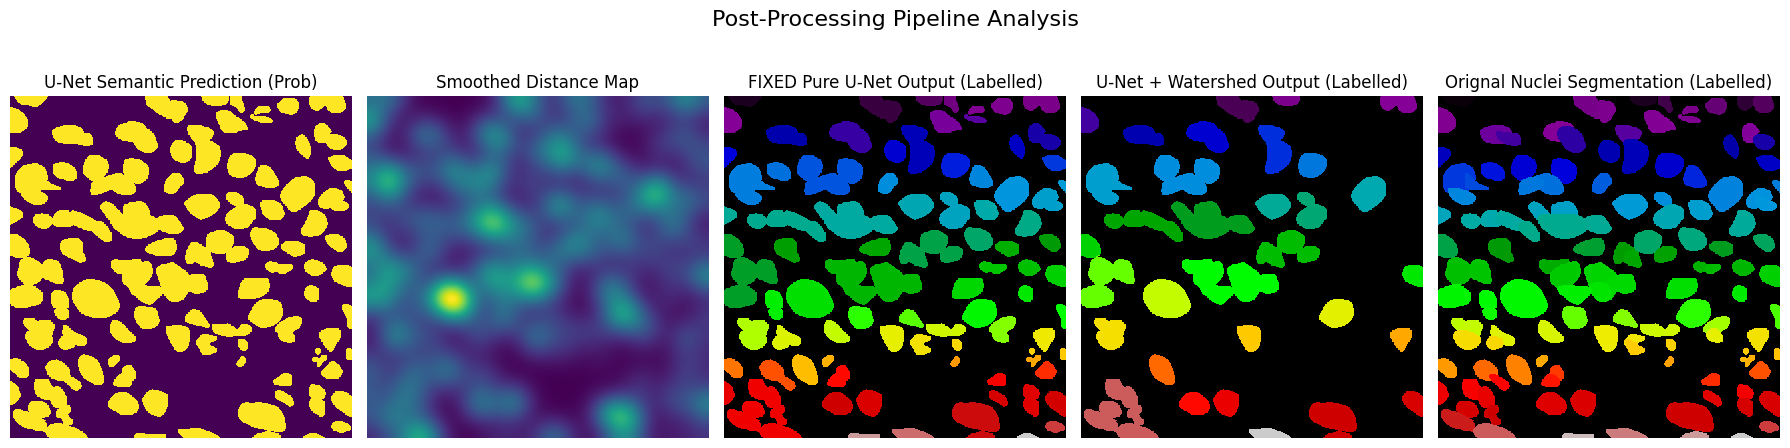


--- Verification ---
Pure U-Net Object Count: 85 (Should now be > 0)
U-Net + Watershed Object Count: 32


In [42]:

# Visualization
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
titles = [
    "U-Net Semantic Prediction (Prob)", 
    "Smoothed Distance Map",
    "FIXED Pure U-Net Output (Labelled)", 
    "U-Net + Watershed Output (Labelled)",
    "Orignal Nuclei Segmentation (Labelled)"
]
images = [
    pred_seg_prob, 
    smoothed_dis, 
    output_raw, 
    output_watershed,
    label_mask
    
]

for ax, img, title in zip(axes, images, titles):
    # Use 'nipy_spectral' for labeled output to distinguish instances
    cmap = 'nipy_spectral' if title.endswith('(Labelled)') else 'viridis'
    ax.imshow(img, cmap=cmap, interpolation='none')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.suptitle("Post-Processing Pipeline Analysis", fontsize=16)
plt.tight_layout()
plt.show()

# Print out object counts for verification
print("\n--- Verification ---")
print(f"Pure U-Net Object Count: {output_raw.max()} (Should now be > 0)")
print(f"U-Net + Watershed Object Count: {output_watershed.max()}")

In [49]:
## disabeling warning msg
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
import warnings
warnings.simplefilter('ignore')
import sys
sys.stdout.flush() # resolving tqdm problem

In [43]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

In [44]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
#####################################################################################
def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
#####################################################################################################################
def mse_score(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [45]:
def dual_decoder_unet_binary(IMG_CHANNELS, LearnRate):
    inputs = Input((None, None, IMG_CHANNELS))
    #encoder
    s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)


    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    ## decoder for dis unet
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs1 = Conv2D(1, (1, 1), activation='linear', name='output_dis')(c9)


    ## decoder for segmentation unet
    u6_seg = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_seg = concatenate([u6_seg, c4])
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_seg)
    c6_seg = Dropout(0.2)(c6_seg)
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_seg)

    u7_seg = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_seg)
    u7_seg = concatenate([u7_seg, c3])
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_seg)
    c7_seg = Dropout(0.2)(c7_seg)
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_seg)

    u8_seg = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_seg)
    u8_seg = concatenate([u8_seg, c2])
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_seg)
    c8_seg = Dropout(0.1)(c8_seg)
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_seg)

    u9_seg = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_seg)
    u9_seg = concatenate([u9_seg, c1], axis=3)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_seg)
    c9_seg = Dropout(0.1)(c9_seg)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_seg)

    outputs2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_seg')(c9_seg)

    model_dual_path = models.Model(inputs=[inputs], outputs=[outputs1, outputs2])
    model_dual_path.compile(optimizer=Adam(learning_rate=LearnRate),
                            loss={'output_dis': 'mean_squared_error', 'output_seg': bce_dice_loss},
                            loss_weights=  {'output_dis': 1.0, 'output_seg': 1.0},
                            metrics={'output_seg':dice_coef, 'output_dis':mse_score})
    # model_dual_path.summary()
    return model_dual_path

In [46]:
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    #print(len(pred_id_list))
    if len(pred_id_list) == 1:
        return 0

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    #print(aji_score)
    return aji_score

#############################################################################################################
def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing. 
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.    
    
    Fast computation requires instance IDs are in contiguous orderding 
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand 
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    
    if len(pred_id_list) == 1:
        return [0, 0, 0], [0,0, 0, 0]

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


#############################################################################################################
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    dice_score = 2.0 * np.sum(inter) / (np.sum(denom) + 0.0001)
    if np.sum(inter)==0 and np.sum(denom)==0:
        dice_score = 1 # to handel cases without any nuclei
    #print(dice_score)
    return dice_score
#############################################################################################################
def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

In [47]:
# set all hyper parameters
opts = {}
opts['number_of_channel'] = 3                   
opts['treshold'] = 0.5                          
opts['epoch_num'] = 120                   
opts['quick_run'] = 1   
opts['batch_size'] = 8                         
opts['random_seed_num'] = 19   
opts['k_fold'] = 2                          
opts['save_val_results'] = 1         
opts['init_LR'] = 0.001                         
opts['LR_decay_factor'] = 0.5                   
opts['LR_drop_after_nth_epoch'] = 20            
opts['crop_size'] = 512   
## output directories
opts['result_save_path'] ='/kaggle/working/prediction_image/'
opts['model_save_path'] ='/kaggle/working/output_model/'

In [50]:
base_path = 'Dataset/'
organ_names = [ name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) ]
organ_names

['human bladder',
 'human brain',
 'human cardia',
 'human cerebellum',
 'human epiglottis',
 'human jejunum',
 'human kidney',
 'human liver',
 'human lung',
 'human melanoma',
 'human muscle',
 'human oesophagus',
 'human pancreas',
 'human peritoneum',
 'human placenta',
 'human pylorus',
 'human rectum',
 'human salivory gland',
 'human spleen',
 'human testis',
 'human tongue',
 'human tonsile',
 'human umbilical cord',
 'mouse fat (white and brown)_subscapula',
 'mouse femur',
 'mouse heart',
 'mouse kidney',
 'mouse liver',
 'mouse muscle_tibia',
 'mouse spleen',
 'mouse thymus']

In [56]:
import os
from glob import glob

img_path = glob('{}*{}'.format('Dataset/*/tissue images/', 'png'))
binary_mask_path = glob('{}*{}'.format('Dataset/*/mask binary/', 'png'))
distance_mask_path = glob('{}*{}'.format('Dataset/*/distance maps/', 'png'))
label_mask_path = glob('{}*{}'.format('Dataset/*/label masks modify/', 'tif'))
vague_mask_path =  glob('{}*{}'.format('Dataset/*/vague areas/mask binary/', 'png'))


img_path.sort()
binary_mask_path.sort()
distance_mask_path.sort()
label_mask_path.sort()
vague_mask_path.sort()


# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('/kaggle/working/prediction_image/'):
    os.makedirs('/kaggle/working/prediction_image/')
if not os.path.exists('/kaggle/working/output_model/'):
    os.makedirs('/kaggle/working/output_model/')    
if not os.path.exists(opts['result_save_path']+ 'validation/unet'):
    os.makedirs(opts['result_save_path'] + 'validation/unet')
if not os.path.exists(opts['result_save_path']+ 'validation/watershed_unet'):
    os.makedirs(opts['result_save_path'] + 'validation/watershed_unet')  

In [57]:
from random import shuffle
import cv2
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
import tqdm

In [58]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = KFold(n_splits= opts['k_fold'],random_state= opts['random_seed_num'],shuffle=True)
kf.get_n_splits(img_path)

2

In [59]:
def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')
    
def chunker(seq, seq2, seq3, size):
    return ([seq[pos:pos + size], seq2[pos:pos + size], seq3[pos:pos + size]] for pos in range(0, len(seq), size))

def data_gen(list_files, list_files2, list_files3, batch_size, p , size_row, size_col, distance_unet_flag = 0,
             augment= False, BACKBONE_model = None, use_pretrain_flag = 1):
    while True:
        for batch in chunker(list_files, list_files2, list_files3, batch_size):
            Y = []
            Y_seg = []
            Y_dis = []
            X = []
            
            image_paths = batch[0]
            mask_paths = batch[1]
            dis_paths = batch[2] 

            for count in range(len(image_paths)):
                # 1. Load Image (X)
                x = cv2.imread(image_paths[count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
                
                # 2. Load Segmentation Mask (Y_seg) - For output_seg
                seg_mask = cv2.imread(mask_paths[count], cv2.IMREAD_GRAYSCALE)
                
                # 3. Load Distance Map (Y_dis) - For output_dis
                dis_map = cv2.imread(dis_paths[count], cv2.IMREAD_GRAYSCALE)

                x = x.astype(np.float32)
                x = x/255.0
                
                seg_mask = (seg_mask > 0).astype(np.float32) 
                
                # Normalize distance map (Regression: 0.0 to 1.0)
                # Your old distance normalization logic (good for distance maps):
                dis_map = dis_map.astype(np.float32)
                min_dis = np.min(dis_map)
                max_dis = np.max(dis_map)
                dis_map = (dis_map - min_dis) / (max_dis - min_dis + 0.0000001)

                X.append(x)
                Y_seg.append(seg_mask)
                Y_dis.append(dis_map)
                
                del x, seg_mask, dis_map
            X = np.array(X)
            Y_seg = np.expand_dims(np.array(Y_seg), axis=-1)
            Y_dis = np.expand_dims(np.array(Y_dis), axis=-1)
            yield X, {'output_seg': Y_seg, 'output_dis': Y_dis}

In [60]:
num_folds = opts['k_fold']
total_images = len(img_path)
max_fold_size = (total_images + num_folds - 1) // num_folds

# Initialize all arrays using the calculated maximum fold size
dice_unet = np.zeros([num_folds, max_fold_size])
AJI_unet = np.zeros([num_folds, max_fold_size])
PQ_unet = np.zeros([num_folds, max_fold_size])

dice_unet_watershed = np.zeros([num_folds, max_fold_size])
AJI_unet_watershed = np.zeros([num_folds, max_fold_size])
PQ_unet_watershed = np.zeros([num_folds, max_fold_size])

dice_unet_watershed_without_vague = np.zeros([num_folds, max_fold_size])
AJI_unet_watershed_without_vague = np.zeros([num_folds, max_fold_size])
PQ_unet_watershed_without_vague = np.zeros([num_folds, max_fold_size])

dice_mean = []
aji_mean = []
pq_mean = []
                   
dice_watershed_mean = []
aji_watershed_mean = []
pq_watershed_mean = []
                   
dice_watershed_wovague_mean = []
aji_watershed_wovague_mean = []
pq_watershed_wovague_mean = []

In [78]:
import random
import numpy as np
import cv2
import time
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import skimage.morphology
from skimage.io import imsave
from skimage.morphology import remove_small_objects
import tqdm
import pandas as pd

# -----------------------------
# Load one random image from dataset
# -----------------------------
random_idx = 100

test_img_path   = img_path[random_idx]
test_mask_path  = binary_mask_path[random_idx]
test_DIS_path   = distance_mask_path[random_idx]
test_label_path = label_mask_path[random_idx]

print(f"Selected test image: {test_img_path}")

# -----------------------------
# Load test image and label
# -----------------------------
val_img = cv2.imread(test_img_path)
val_img = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
val_img = val_img.astype(np.float32) / 255.0
val_img = np.expand_dims(val_img, axis=0)  # model expects batch dimension

val_label = cv2.imread(test_label_path, -1)
validation_set_label = np.expand_dims(val_label, axis=0)

# -----------------------------
# Load Model and Weights
# -----------------------------
model_path = 'unet_1.weights.h5'  # specify fold or latest weights
model = dual_decoder_unet_binary(opts['number_of_channel'], opts['init_LR'])
model.load_weights(model_path)

print("Model weights loaded successfully.")



Selected test image: Dataset\human liver\tissue images\human_liver_21.png
Model weights loaded successfully.


In [79]:
# -----------------------------
# Run Inference
# -----------------------------
start_time = time.time()
pred_val = model.predict(val_img, verbose=1, batch_size=1)
pred_dis, pred_seg = pred_val[0], pred_val[1]
pred_val_t = (pred_seg > opts['treshold']).astype(np.uint8)
end_time = time.time()

print(f"Inference completed in {end_time - start_time:.2f} seconds.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Inference completed in 2.11 seconds.


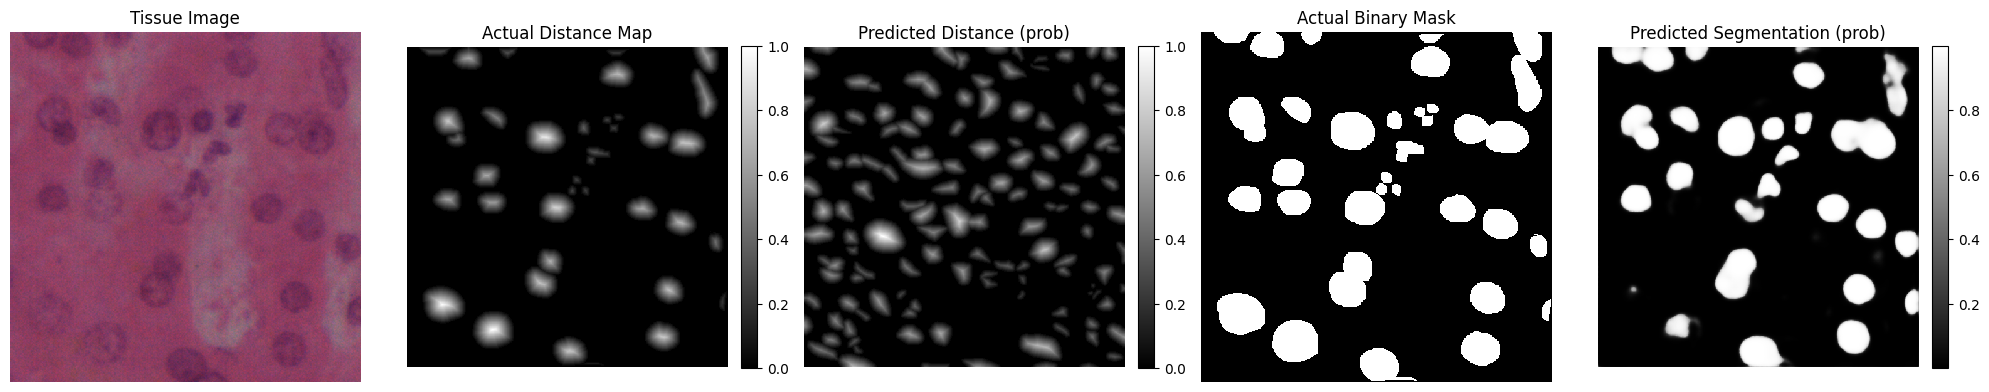

In [80]:
# Display tissue image, actual distance & binary, predicted distance and predicted segmentation prob
tissue_img = val_img[0]                # (H, W, 3), float in [0,1]

# prefer predicted distance probability if available
if 'pred_dis_prob' in globals():
    pred_distance = np.squeeze(pred_dis_prob)
elif 'pred_dis' in globals():
    pred_distance = np.squeeze(pred_dis)
else:
    # pred_distance = np.zeros(tissue_img.shape[:2])
    print("Warning: Predicted distance map not found, using zeros.")

pred_seg_prob = np.squeeze(pred_seg)   # ensure 2D

# Load actual distance and binary mask from the selected test paths if possible,
# otherwise fall back to any existing variables
try:
    actual_distance = imread(test_DIS_path)
except Exception:
    # actual_distance = globals().get('distance_mask', np.zeros(tissue_img.shape[:2]))
    print("Warning: Actual distance map not found, using zeros.")

try:
    actual_binary = imread(test_mask_path)
except Exception:
    # actual_binary = globals().get('binary_mask', np.zeros(tissue_img.shape[:2]))
    print("Warning: Actual binary mask not found, using zeros.")

# If the loaded maps are multi-channel, reduce to single channel
# if actual_distance.ndim == 3:
#     actual_distance = actual_distance[..., 0]
# if actual_binary.ndim == 3:
#     actual_binary = actual_binary[..., 0]

# Normalization helper for display (maps -> [0,1])
def norm01(arr):
    a = arr.astype(float)
    amin, amax = a.min(), a.max()
    if amax - amin == 0:
        return np.zeros_like(a)
    return (a - amin) / (amax - amin + 1e-12)

actual_distance_disp = norm01(actual_distance)
pred_distance_disp = norm01(pred_distance)
pred_seg_disp = np.clip(pred_seg_prob.astype(float), 0.0, 1.0)
actual_binary_disp = (actual_binary > 0).astype(float)

# Plot: Tissue | Actual Distance | Predicted Distance | Actual Binary Mask | Predicted Seg Prob
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].imshow(tissue_img, interpolation='none')
axes[0].set_title('Tissue Image')
axes[0].axis('off')

im1 = axes[1].imshow(actual_distance_disp, cmap='gray', interpolation='none')
axes[1].set_title('Actual Distance Map')
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(pred_distance_disp, cmap='gray', interpolation='none')
axes[2].set_title('Predicted Distance (prob)')
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

axes[3].imshow(actual_binary_disp, cmap='gray', interpolation='none')
axes[3].set_title('Actual Binary Mask')
axes[3].axis('off')

im3 = axes[4].imshow(pred_seg_disp, cmap='gray', interpolation='none')
axes[4].set_title('Predicted Segmentation (prob)')
axes[4].axis('off')
fig.colorbar(im3, ax=axes[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Ensure same shape and valid float range
actual_distance_resized = cv2.resize(actual_distance_disp, pred_distance_disp.shape[::-1])
pred_distance_resized = pred_distance_disp

# Flatten for numeric metrics
y_true = actual_distance_resized.flatten().astype(np.float32)
y_pred = pred_distance_resized.flatten().astype(np.float32)

# Compute error metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
ssim_val = ssim(actual_distance_resized, pred_distance_resized, data_range=1.0)

print("========== Distance Map Comparison ==========")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error  (MSE): {mse:.6f}")
print(f"Structural Similarity (SSIM): {ssim_val:.4f}")
print("==============================================")


========== Distance Map Comparison ==========
Mean Absolute Error (MAE): 0.116066
Mean Squared Error  (MSE): 0.040130
Structural Similarity (SSIM): 0.4017


In [92]:
# Run the fixed pipeline
output_watershed, output_raw, smoothed_dis = \
    post_process_nuclei(actual_distance, pred_seg_prob, THRESHOLD, MIN_SIZE)
# post_process_nuclei(pred_distance, pred_seg_prob, THRESHOLD, MIN_SIZE)

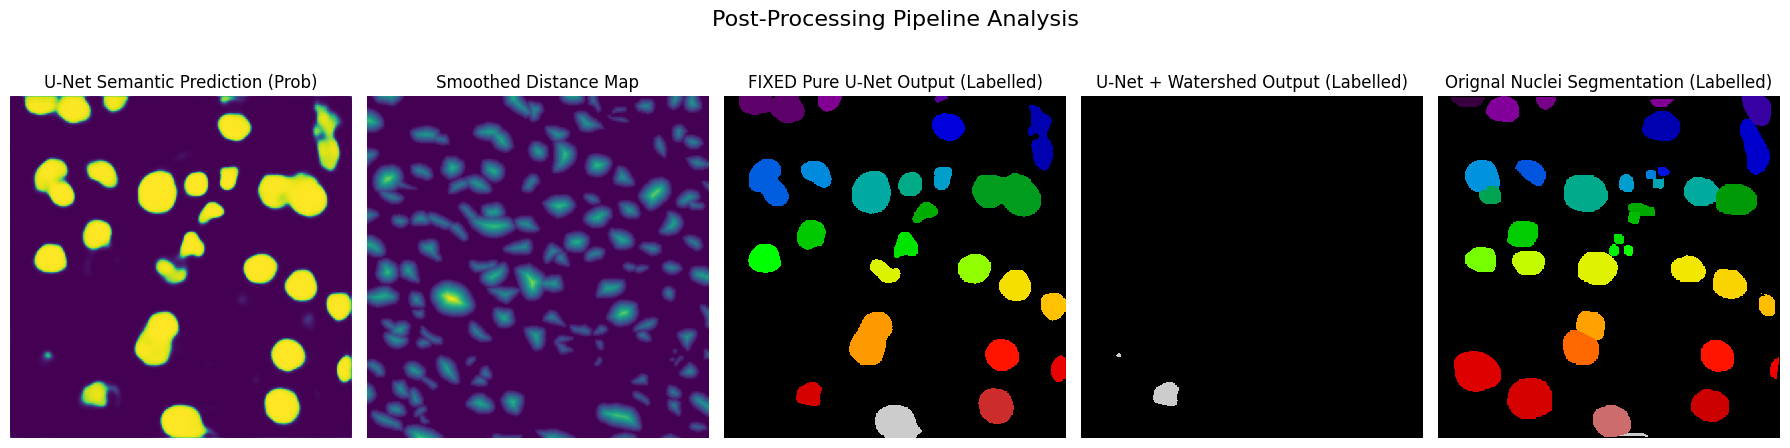


--- Verification ---
Pure U-Net Object Count: 25 (Should now be > 0)
U-Net + Watershed Object Count: 1


In [93]:

# Visualization
fig, axes = plt.subplots(1, 5, figsize=(18, 5))
titles = [
    "U-Net Semantic Prediction (Prob)", 
    "Smoothed Distance Map",
    "FIXED Pure U-Net Output (Labelled)", 
    "U-Net + Watershed Output (Labelled)",
    "Orignal Nuclei Segmentation (Labelled)"
]
images = [
    pred_seg_prob, 
    pred_distance,
    # smoothed_dis, 
    output_raw, 
    output_watershed,
    val_label
    
]

for ax, img, title in zip(axes, images, titles):
    # Use 'nipy_spectral' for labeled output to distinguish instances
    cmap = 'nipy_spectral' if title.endswith('(Labelled)') else 'viridis'
    ax.imshow(img, cmap=cmap, interpolation='none')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.suptitle("Post-Processing Pipeline Analysis", fontsize=16)
plt.tight_layout()
plt.show()

# Print out object counts for verification
print("\n--- Verification ---")
print(f"Pure U-Net Object Count: {output_raw.max()} (Should now be > 0)")
print(f"U-Net + Watershed Object Count: {output_watershed.max()}")

In [94]:
# -----------------------------
# Post-Processing
# -----------------------------
for val_len in tqdm.tqdm(range(len(pred_dis))):
    avg_nuclei = calculate_average_nucleus_diameter(pred_seg[val_len])
    pred_dis[val_len] = apply_gaussian_smoothing(pred_dis[val_len], avg_nuclei)

    # detect local maxima
    peak_coords = peak_local_max(
        np.squeeze(pred_dis[val_len]),
        exclude_border=False,
        footprint=np.ones((15, 15))
    )

    image_shape = np.squeeze(pred_dis[val_len]).shape
    local_maxi = np.zeros(image_shape, dtype=bool)
    if peak_coords.size > 0:
        local_maxi[peak_coords[:, 0], peak_coords[:, 1]] = True

    marker = ndi.label(local_maxi)[0]
    output_watershed = watershed(
        -np.squeeze(pred_dis[val_len]),
        marker,
        mask=np.squeeze(pred_val_t[[val_len]])
    )
    output_watershed[np.squeeze(pred_seg[[val_len]]) == 0] = 0
    output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)

    # Binary mask and label
    output_raw_binarized = (np.squeeze(pred_seg[val_len]) > opts['treshold']).astype(np.uint8)
    output_raw = skimage.morphology.label(output_raw_binarized)
    output_raw = remove_small_objects(output_raw, min_size=50, connectivity=2)

    # Remap labels for consistency
    output_watershed = remap_label(output_watershed)
    validation_set_label[val_len] = remap_label(validation_set_label[val_len])
    output_raw = remap_label(output_raw)

    # -----------------------------
    # Save Results
    # -----------------------------
    test_name = get_id_from_file_path(test_img_path, '.png')
    imsave(opts['result_save_path'] + f'validation/watershed_unet/{test_name}.png',
           output_watershed.astype(np.uint16))
    imsave(opts['result_save_path'] + f'validation/unet/{test_name}.png',
           output_raw.astype(np.uint16))

    # -----------------------------
    # Compute Metrics
    # -----------------------------
    dice = get_dice_1(validation_set_label[val_len], output_raw)
    aji = get_fast_aji(validation_set_label[val_len], output_raw)
    pq = get_fast_pq(validation_set_label[val_len], output_raw)[0][2]

    dice_w = get_dice_1(validation_set_label[val_len], output_watershed)
    aji_w = get_fast_aji(validation_set_label[val_len], output_watershed)
    pq_w = get_fast_pq(validation_set_label[val_len], output_watershed)[0][2]

    print("========== RESULTS ==========")
    print(f"Dice (Unet): {dice*100:.2f}")
    print(f"AJI  (Unet): {aji*100:.2f}")
    print(f"PQ   (Unet): {pq*100:.2f}")
    print("------------------------------")
    print(f"Dice (Watershed): {dice_w*100:.2f}")
    print(f"AJI  (Watershed): {aji_w*100:.2f}")
    print(f"PQ   (Watershed): {pq_w*100:.2f}")
    print("==============================")


print("✅ Inference and post-processing completed successfully.")


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

========== RESULTS ==========
Dice (Unet): 78.58
AJI  (Unet): 45.79
PQ   (Unet): 36.56
------------------------------
Dice (Watershed): 0.00
AJI  (Watershed): 0.00
PQ   (Watershed): 0.00
✅ Inference and post-processing completed successfully.


# The Binary Maps decoder works fine but the distance map decoder does not work at all. Need to troubleshoot why that is the case.